<a href="https://colab.research.google.com/github/dabeesknees48/Medium-code/blob/main/datasciencefinal_medium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 6.4 MB 12.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import statsmodels.api as sm
import warnings
import time
import os
import math
import statsmodels.tsa.stattools as st
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
plt.rcParams['figure.figsize'] = [12, 8]
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# copycat of the tic toc feature in matlab 
def TicTocGenerator():
    ti = 0          
    tf = time.time()
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti
TicToc = TicTocGenerator()
def toc(tempBool=True):
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval )
def tic():
    toc(False)

In [ ]:
# Function moveavg plots given dataframe with the chosen moving days and std
def moveavg(df,symbol,di,std):
    move=pd.Series(df['Close'])
    moveavg=move.rolling(di).mean()
    movelowertheta=moveavg-std*move.rolling(di).std()
    moveuppertheta=moveavg+std*move.rolling(di).std()
    lastp = move.values[-1]
    lastlb = movelowertheta.values[-1]
    lastub = moveuppertheta.values[-1]
    if (lastp < lastlb):dis = 1
    elif (lastp > lastub):dis = 0
    elif lastp > (2*(lastub-lastlb)/3)+lastlb: dis = .25
    elif lastp < (lastub-lastlb)/3+lastlb: dis = .75
    else: dis = .5
    indis.append([symbol,round(move.values[-1],2),di,'SMA',dis])

In [ ]:
#tests if timeseries ts is stationary 
def stationary(ts,name):
    fullerstats = st.adfuller(ts.dropna())
    if (fullerstats[1] > .05):
      print(name + " Non - Stationary")
      print('ADF Statistic: %f' % fullerstats[0])
      print('p-value: %f' % fullerstats[1])

In [ ]:
# RSI function calcuates rsi with optimal parameters based on recent data / optimalization is based on how much of the #data enclapsed 
def rsi(df,symbol):
    # relative strength days
    dr = df['Close'].diff() # price differences
    dup, ddown = dr.copy(), dr.copy()
    dup[dup < 0] = 0 # replaces all neg with 0 for days of gain
    ddown[ddown > 0] = 0 # replaces all pos with 0 for days of loss
    avggain = dup.rolling(14).mean()
    avgloss = ddown.rolling(14).mean().abs()
    rs = avggain / avgloss
    rsi= 100.0 - (100.0 / (1.0 + rs))
    rsi=rsi[-1]
    if rsi<=20: signal = 1
    elif rsi>80:signal = 0
    elif rsi>20 and rsi <=40: signal = .25
    elif rsi>60 and rsi <=80: signal = .75
    else: signal = .5
    indis.append([symbol,rsi,14,'RSI',signal])

In [ ]:
def optimize(orderlist, e):
    res = []
    for order in orderlist:
        try: 
            model = SARIMAX(e, order=order).fit(disp=-1)
        except:
            continue    
        aic = model.aic
        res.append([order, model.aic])        
    resdf = pd.DataFrame(res)
    resdf.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order we are using 5 lowest
    resdf = resdf.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return resdf

In [ ]:
#checks if the residual of the model is white noise
def whitenoise(testmodel): 
    ljungbox, pvalue = acorr_ljungbox(testmodel.resid)#using the pvalue of the ljungbox test if below .05 
    if pvalue[5]>.05 :
        return True
    else :
        return False

In [ ]:
def top5(dr): # gets all terms up to 5,1,5
  terms = product(range(6), range(6))
  plist = list(terms)
  order = []
  for each in plist:
      each = list(each)
      each.insert(1, 1)
      each = tuple(each)
      order.append(each)
  return optimize(order,dr)

In [ ]:
# generates signal from 5 different predictions from arima models
def arima5(df,symbol):
    dr = (np.log(df.Close) - np.log(df.Close.shift(1)))*100 #log returns
    dr.dropna(inplace =True)
    stationary(dr,symbol) # checks if time series is stationary
    terms4dr = top5(dr)
    for i in range(5):
        daorder = terms4dr.iloc[i,0]
        bmodr = SARIMAX(dr, order=daorder).fit()
        if whitenoise(bmodr): # checks neccesary condition 
            forecast=float(bmodr.forecast(steps=1)) 
        else: 
            print(symbol,' cant')
            continue
        
        if forecast>=1: signal = 1
        elif forecast<-1:signal = 0
        elif forecast<-.5 and forecast>-1: signal = .25
        elif forecast>.5 and forecast<1: signal = .75
        else: signal = .5
        indis.append([symbol,forecast,999,'ARIMA '+str(daorder),signal])
# if something cant i simply just ignore the stock thats just my workaround    

In [ ]:
#small amount of popular stocks 
stocks = ['AAPL','BAC',"AMZN","TSLA","SHOP","GOOG","PLUG","VZ","COST","WMT","SPY","YOLO","QCOM","IBM","GLD","ALL","SNAP","MRNA"]
stocks = sorted(stocks)

In [ ]:
tic()
three = (datetime.now() - timedelta(480)).strftime('%Y-%m-%d')
fres = []
stocks = ['SPY']#tester since this takes awhile
for stock in stocks:
    symbol = stock
    data = yf.download(stock,start = three)
    fores = []
    for i in reversed(range(1,50)):
        df = data.copy()
        global indis # allows the other methods to append it
        indis = [] 
        live = df[-i:]  
        df = df[:-i] #removes from the data so it doesnt know the future
        moveavg(df,stock,10,1.5)#fidelity short term
        moveavg(df,stock,20,2)#fidelity mid term
        moveavg(df,stock,50,2.5)#fidelity long term
        moveavg(df,stock,200,3) 
        rsi(df,stock)#rsi
        arima5(df,stock)#5 arima models
        dindis = pd.DataFrame(indis,columns=['SYMBOL','PRICE','LAG','INDI','SIGNAL'])
        sigcount = dindis[dindis.SYMBOL==stock].groupby('SIGNAL').size()
        sell = 0
        buy = 0
        daindex = list(sigcount.index)
        if 0 in daindex:sell += sigcount[0]
        if .25 in daindex:sell += .5*(sigcount[.25])
        if .75 in daindex:buy += .5*(sigcount[.75])
        if 1 in daindex:buy += sigcount[1]
        pred = max(buy,sell)
        conf = pred/10
        sig = 'sus' # placeholder
        if pred == buy: sig='Buy'
        if pred == sell: sig = 'Sell'
        fc = (df.index[-1],sig,conf)
        fores.append(fc)
        res = pd.DataFrame(fores,columns=['Date','bs','conf'])
        res.index = res.Date
        res.drop(columns='Date',inplace = True)
        df = data.copy()
        df['dr'] = df['Close'].diff()
        df = df[-48:]
        df['bs'] = res.bs
        df['conf'] = res.conf
        df['result'] = 0 
        for j in range(len(df)-1):
            #previous day action and close price
            pred = df.bs[j]
            close = df.Close[j]
            #if buy compare to next day high
            if pred == 'Buy':
                if close < df.High[j+1]: df.result[j]=1 
            #if sell compare to next day low
            if pred == 'Sell':
                if close > df.Low[j+1]: df.result[j]=1
        dajuice = (stock,(df.result.sum()/48))
    fres.append(dajuice)
toc()

[*********************100%***********************]  1 of 1 completed
Elapsed time: 1120.772682 seconds.



In [ ]:
#test from spy
fres

[('SPY', 0.8541666666666666)]

In [ ]:
#the original test
fres

[('AAPL', 0.8958333333333334),
 ('ALL', 0.8541666666666666),
 ('AMZN', 0.8333333333333334),
 ('BAC', 0.75),
 ('COST', 0.8125),
 ('GLD', 0.7083333333333334),
 ('GOOG', 0.8541666666666666),
 ('IBM', 0.8958333333333334),
 ('MRNA', 0.7916666666666666),
 ('PLUG', 0.875),
 ('QCOM', 0.9166666666666666),
 ('SHOP', 0.8333333333333334),
 ('SNAP', 0.8333333333333334),
 ('SPY', 0.8541666666666666),
 ('TSLA', 0.8125),
 ('VZ', 0.875),
 ('WMT', 0.8958333333333334),
 ('YOLO', 0.8333333333333334)]

Everything under is scrath code ill leave it in case you wish to play with it

In [ ]:
df['result']=0
for j in range(len(df)-1):
    #previous day action and close price
    pred = df.bs[j]
    close = df.Close[j]
    #if buy compare to next day high
    if pred == 'Buy':
        if close < df.High[j+1]: df.result[j]=1 
    #if sell compare to next day low
    if pred == 'Sell':
        if close > df.Low[j+1]: df.result[j] =1
df

,Open,High,Low,Close,Adj Close,Volume,dr,bs,conf,result
Date,,,,,,,,,,
2021-12-27,1073.670044,1117.000000,1070.719971,1093.939941,1093.939941,23715300,26.939941,Sell,0.20,1
2021-12-28,1109.489990,1119.000000,1078.420044,1088.469971,1088.469971,20108000,-5.469971,Sell,0.15,1
2021-12-29,1098.640015,1104.000000,1064.140015,1086.189941,1086.189941,18718000,-2.280029,Sell,0.15,1
2021-12-30,1061.329956,1095.550049,1053.150024,1070.339966,1070.339966,15680300,-15.849976,Sell,0.15,1
2021-12-31,1073.439941,1082.000000,1054.589966,1056.780029,1056.780029,13577900,-13.559937,Sell,0.10,0
2022-01-03,1147.750000,1201.069946,1136.040039,1199.780029,1199.780029,34643800,143.000000,Sell,0.30,1
2022-01-04,1189.550049,1208.000000,1123.050049,1149.589966,1149.589966,33416100,-50.190063,Buy,0.25,1
2022-01-05,1146.650024,1170.339966,1081.010010,1088.119995,1088.119995,26706600,-61.469971,Buy,0.30,0
2022-01-06,1077.000000,1088.000000,1020.500000,1064.699951,1064.699951,30112200,-23.420044,Buy,0.10,1


In [ ]:
df.groupby('result').size()

result
0     9
1    39
dtype: int64

In [ ]:
#targets = []
def discrete(forecast):
    if forecast>=1: signal = 1
    elif forecast<-1:signal = 0
    elif forecast<0 and forecast>-1: signal = .25
    elif forecast>0 and forecast<1: signal = .75
    else: signal = .5
    targets.append(signal)
#for i in range(len(last)):discrete(last[i])

In [ ]:
fc = pd.DataFrame(index = stocks,columns = ['B/S','Conf'])
for i in range(len(stocks)):
    stock = stocks[i]
    sigcount = dindis[dindis.SYMBOL==stock].groupby('SIGNAL').size()
    sell = 0
    buy = 0
    daindex = list(sigcount.index)
    if 0 in daindex:sell += sigcount[0]
    if .25 in daindex:sell += .5*(sigcount[.25])
    if .75 in daindex:buy += .5*(sigcount[.75])
    if 1 in daindex:buy += sigcount[1]
    pred = max(buy,sell)
    conf = pred/10
    if pred == buy: 
        fc.loc[stock]['B/S']='Buy'
        fc.loc[stock]['Conf'] = conf
    if pred == sell: 
        fc.loc[stock]['B/S'] = 'Sell'
        fc.loc[stock]['Conf'] = conf

In [ ]:
fc

,B/S,Conf
AAPL,Buy,0.3
ALL,Sell,0.15
AMZN,Sell,0.45
BAC,Buy,0.45
COST,Sell,0.5
GLD,Sell,0.25
GOOG,Buy,0.65
IBM,Sell,0.35
MRNA,Sell,0.55
PLUG,Buy,0.3


[*********************100%***********************]  1 of 1 completed


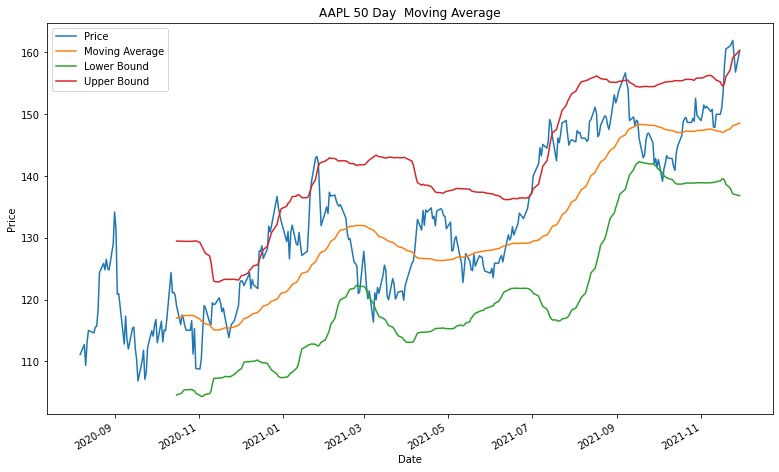

In [ ]:
#sma graph
symbol = 'AAPL'
df=yf.download(symbol,start = three)
axis=df['Close'].plot()
move=pd.Series(df['Close'])
moveavg=move.rolling(50).mean()
moveavg.plot(title= symbol + ' ' +str(50) +' Day '+" Moving Average")
movelowertheta=moveavg-2*move.rolling(50).std()
movelowertheta.plot()
moveuppertheta=moveavg+2*move.rolling(50).std()
moveuppertheta.plot()
axis.set_xlabel("Date")
axis.set_ylabel("Price")
axis.legend(["Price","Moving Average","Lower Bound","Upper Bound"],loc='upper left')
#plt.savefig('charts/{}.pdf'.format(name))
plt.show()

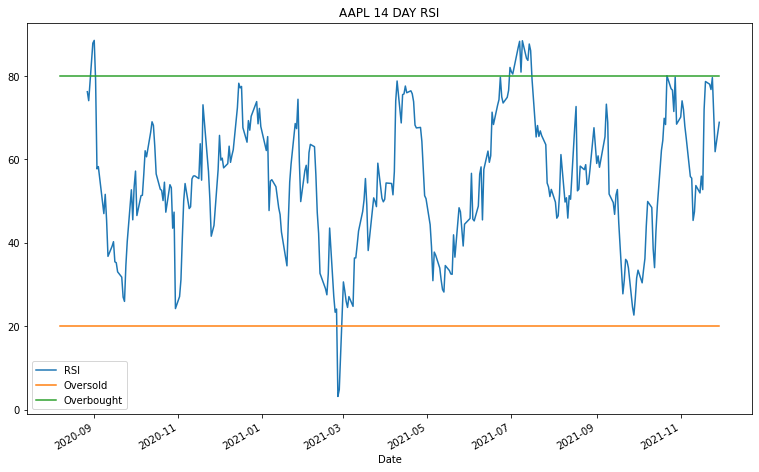

In [ ]:
# relative strengtht days
dr = df['Close'].diff() # price differences
dup, ddown = dr.copy(), dr.copy()
dup[dup < 0] = 0 # replaces all neg with 0 for days of gain
ddown[ddown > 0] = 0 # replaces all pos with 0 for days of loss
avggain = dup.rolling(14).mean()
avgloss = ddown.rolling(14).mean().abs()
rs = avggain / avgloss
rsi= 100.0 - (100.0 / (1.0 + rs))
os = [20 for i in range(len(rsi))]
os = pd.Series(os,index=rsi.index)
ob = [80 for i in range(len(rsi))]
ob = pd.Series(ob,index=rsi.index)
ax = rsi.plot(label = 'RSI',title='AAPL 14 DAY RSI')
os.plot(label = 'Oversold')
ob.plot(label = 'Overbought')
ax.legend(loc='lower left')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(13, 8))
# Plot the data (here we are subsetting it to get a better look at the forecasts)
dr = df.pct_change().dropna()
dr.Close = dr.Close*100
dr.reset_index(inplace=True)
# Construct the forecasts
drmodel = SARIMAX(dr.Close, order=(3,1,5)).fit() #ARIMA model used random order just to showcase
dr['Forecast'] = drmodel.predict(start=len(dr)-18,end=len(dr),dynamic=True)

In [ ]:
dr.dropna(inplace=True)
dr

,Date,Open,High,Low,Close,Adj Close,Volume,Forecast
312,2021-11-03,0.011637,0.002639,0.007871,0.979870,0.009799,-0.211373,-0.216601
313,2021-11-04,0.007913,0.003027,0.005473,-0.349857,-0.003499,0.107924,0.461129
314,2021-11-05,0.002045,-0.001509,-0.003850,0.211971,0.003582,0.083120,0.112584
315,2021-11-08,-0.003160,-0.004139,0.000666,-0.555259,-0.005553,-0.158890,-0.194308
316,2021-11-09,-0.007992,-0.000924,-0.000666,0.245942,0.002459,0.032115,0.310753
317,2021-11-10,-0.001198,-0.008585,-0.014727,-1.916318,-0.019163,0.147905,0.302251
318,2021-11-11,-0.007066,-0.004663,-0.001150,-0.033804,-0.000338,-0.371041,-0.249283
319,2021-11-12,-0.003558,0.006491,-0.001354,1.433699,0.014337,0.552015,0.226237
320,2021-11-15,0.013070,0.009840,0.013222,0.006663,0.000067,-0.069301,0.358738
321,2021-11-16,-0.002860,-0.002568,-0.000602,0.666667,0.006667,0.000564,-0.149297


In [ ]:
df['forecast']=dr.Forecast

In [ ]:
for i in list(dr.index):
  df.forecast[i+1] = df.Close[i]*(1-(dr.Forecast[i]/100))

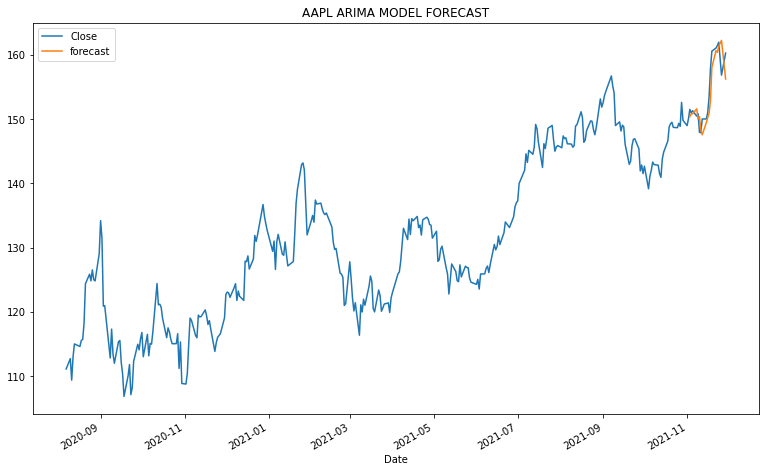

In [ ]:
df[['Close','forecast']].plot(title='AAPL ARIMA MODEL FORECAST')

In [ ]:
fcast

Close,mean,mean_se,mean_ci_lower,mean_ci_upper
330,-0.177834,1.855659,-3.814858,3.459190
331,0.472959,1.855661,-3.164070,4.109987
332,-0.047097,1.856644,-3.686053,3.591860
333,0.031908,1.857706,-3.609129,3.672945
334,0.428955,1.858229,-3.213107,4.071018
